In [1]:
#Import dependencies
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
hv.extension('bokeh')

In [3]:
# Set pandas display options
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [5]:
#Define Functions

# Define RSI function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Define Bollinger Band function
def calculate_bollinger_bands(data, window=20):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    upper_band = sma + (2 * std)
    lower_band = sma - (2 * std)
    return upper_band, lower_band

# Function to calculate daily volatility
def calculate_daily_volatility(prices):
    returns = prices.pct_change(fill_method=None)
    volatility = returns.rolling(window=21).std() * np.sqrt(252)  # Annualized daily volatility
    return volatility

In [7]:
# Fetch S&P 500 tickers
#Define dates
start_date = '2020-01-01'
end_date = '2024-10-18'

#Get tickers from wikipedia
sp500_tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Filter out Class B shares that have a '.B' in the ticker name
sp500_tickers = [ticker for ticker in sp500_tickers if '.B' not in ticker]

print(f"Initial total S&P 500 tickers: {len(sp500_tickers)}")

Initial total S&P 500 tickers: 501


In [9]:
# Download historical prices
data = yf.download(sp500_tickers, start=start_date, end=end_date)['Adj Close']

# Fill NaN values with 0
data.fillna(0, inplace=True)

# Check if data was downloaded for all tickers
print(f"Successfully downloaded tickers: {len(data.columns)} out of {len(sp500_tickers)}")

[*********************100%***********************]  501 of 501 completed


Successfully downloaded tickers: 501 out of 501


In [10]:
# Display data Frame
data.head(15)

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02 00:00:00+00:00,83.215,72.876,72.265,0.000,79.690,43.400,195.264,334.430,110.378,40.694,...,191.208,24.533,140.138,54.000,56.088,75.451,93.541,139.626,259.140,129.515
2020-01-03 00:00:00+00:00,81.879,72.168,71.579,0.000,78.718,43.350,194.938,331.810,108.435,40.614,...,191.255,24.575,138.059,54.260,55.637,75.895,93.248,139.261,256.050,129.534
2020-01-06 00:00:00+00:00,82.121,72.743,72.144,0.000,79.131,43.520,193.665,333.710,107.161,40.297,...,191.489,24.525,137.786,54.182,56.065,75.404,93.193,138.456,258.010,128.540
2020-01-07 00:00:00+00:00,82.373,72.401,71.732,0.000,78.691,43.160,189.484,333.390,109.599,39.811,...,191.096,24.366,138.440,54.070,55.606,75.120,93.358,138.335,256.470,128.974
2020-01-08 00:00:00+00:00,83.186,73.565,72.241,0.000,79.012,42.730,189.856,337.870,110.589,39.370,...,191.311,24.458,139.309,54.018,54.767,75.376,93.523,139.991,247.640,128.694
2020-01-09 00:00:00+00:00,84.493,75.128,72.797,0.000,79.223,43.600,191.547,340.450,110.589,38.964,...,191.882,24.658,138.723,54.139,55.186,75.716,94.265,139.065,246.500,130.403
2020-01-10 00:00:00+00:00,84.803,75.298,71.869,0.000,78.233,43.530,192.950,339.810,108.673,38.788,...,191.882,24.683,139.562,54.225,54.696,75.536,93.102,140.366,246.270,130.896
2020-01-13 00:00:00+00:00,84.677,76.906,71.434,0.000,78.013,43.690,194.743,345.630,109.122,39.202,...,191.882,25.251,143.661,54.857,55.218,76.802,91.866,139.458,248.580,131.803
2020-01-14 00:00:00+00:00,85.190,75.868,72.137,0.000,78.915,43.670,193.015,344.630,109.553,39.273,...,190.946,25.577,146.413,54.944,54.743,76.887,92.214,138.821,248.070,132.537


In [13]:
# Display tickers that were successfully downloaded
downloaded_tickers = data.columns.get_level_values(0).unique()
print(f"Successfully downloaded tickers: {len(downloaded_tickers)} out of {len(sp500_tickers)}")

Successfully downloaded tickers: 501 out of 501


In [15]:
# Calculate various indicators
returns = data.pct_change()

daily_volatility = data.apply(calculate_daily_volatility)
rsi = data.apply(calculate_rsi)
sma_50 = data.rolling(window=50).mean()
sma_100 = data.rolling(window=100).mean()
sma_200 = data.rolling(window=200).mean()
upper_band, lower_band = calculate_bollinger_bands(data)
support = data.rolling(window=50).min()
resistance = data.rolling(window=50).max()


In [39]:
# Align data lengths by filling forward and backward
returns.ffill(inplace=True)
returns.bfill(inplace=True)
daily_volatility.ffill(inplace=True)
daily_volatility.bfill(inplace=True)
rsi.ffill(inplace=True)
rsi.bfill(inplace=True)
sma_50.ffill(inplace=True)
sma_50.bfill(inplace=True)
sma_100.ffill(inplace=True)
sma_100.bfill(inplace=True)
sma_200.ffill(inplace=True)
sma_200.bfill(inplace=True)
upper_band.ffill(inplace=True)
upper_band.bfill(inplace=True)
lower_band.ffill(inplace=True)
lower_band.bfill(inplace=True)
support.ffill(inplace=True)
support.bfill(inplace=True)
resistance.ffill(inplace=True)
resistance.bfill(inplace=True)

In [41]:
print(f"Returns shape: {returns.shape}")
print(returns.head())

print(f"Daily Volatility shape: {daily_volatility.shape}")
print(daily_volatility.head())

print(f"RSI shape: {rsi.shape}")
print(rsi.head())

print(f"SMA_50 shape: {sma_50.shape}")
print(sma_50.head())

print(f"SMA_100 shape: {sma_100.shape}")
print(sma_100.head())

print(f"SMA_200 shape: {sma_200.shape}")
print(sma_200.head())

print(f"Upper Band shape: {upper_band.shape}")
print(upper_band.head())

print(f"Lower Band shape: {lower_band.shape}")
print(lower_band.head())

print(f"Support shape: {support.shape}")
print(support.head())

print(f"Resistance shape: {resistance.shape}")
print(resistance.head())

Returns shape: (1207, 501)
Ticker                         A   AAPL   ABBV  ABNB    ABT   ACGL    ACN  \
Date                                                                        
2020-01-02 00:00:00+00:00 -0.016 -0.010 -0.009   inf -0.012 -0.001 -0.002   
2020-01-03 00:00:00+00:00 -0.016 -0.010 -0.009   inf -0.012 -0.001 -0.002   
2020-01-06 00:00:00+00:00  0.003  0.008  0.008   inf  0.005  0.004 -0.007   
2020-01-07 00:00:00+00:00  0.003 -0.005 -0.006   inf -0.006 -0.008 -0.022   
2020-01-08 00:00:00+00:00  0.010  0.016  0.007   inf  0.004 -0.010  0.002   

Ticker                      ADBE    ADI    ADM  ...    WTW     WY   WYNN  \
Date                                            ...                        
2020-01-02 00:00:00+00:00 -0.008 -0.018 -0.002  ...  0.000  0.002 -0.015   
2020-01-03 00:00:00+00:00 -0.008 -0.018 -0.002  ...  0.000  0.002 -0.015   
2020-01-06 00:00:00+00:00  0.006 -0.012 -0.008  ...  0.001 -0.002 -0.002   
2020-01-07 00:00:00+00:00 -0.001  0.023 -0.012  ... -

In [45]:
print(f"Return Length: {len(returns)}")
print(f"Data Length: {len(data.index)}")
print(f"Volatility Length: {len(daily_volatility)}")
print(f"RSI Length: {len(rsi)}")
print(f"SMA_50 Length: {len(sma_50)}")
print(f"SMA_100 Length: {len(sma_100)}")
print(f"SMA_200 Length: {len(sma_200)}")
print(f"Upper Band Length: {len(upper_band)}")
print(f"Lower Band Length: {len(lower_band)}")
print(f"Support Length: {len(support)}")
print(f"Resistance Length: {len(resistance)}")


Return Length: 1207
Data Length: 1207
Volatility Length: 1207
RSI Length: 1207
SMA_50 Length: 1207
SMA_100 Length: 1207
SMA_200 Length: 1207
Upper Band Length: 1207
Lower Band Length: 1207
Support Length: 1207
Resistance Length: 1207


In [51]:
# Compile indicators into a single DataFrame
length = len(data) * len(data.columns)
indicators_df = pd.DataFrame({
    'Date': np.repeat(data.index, len(data.columns)),
    'Ticker': np.tile(data.columns, len(data)),
    'Adjusted Close': data.values.flatten(),
    'Return': returns.values.flatten(),
    'Volatility': daily_volatility.values.flatten(),
    'RSI': rsi.values.flatten(),
    'SMA_50': sma_50.values.flatten(),
    'SMA_100': sma_100.values.flatten(),
    'SMA_200': sma_200.values.flatten(),
    'Upper Band': upper_band.values.flatten(),
    'Lower Band': lower_band.values.flatten(),
    'Support': support.values.flatten(),
    'Resistance': resistance.values.flatten(),
})

# Replace inf values with NaN using an assignment
indicators_df['Return'] = indicators_df['Return'].replace([np.inf, -np.inf], np.nan)

# Drop NaN values
indicators_df.dropna(subset=['Adjusted Close', 'Return', 'Volatility', 'RSI', 'SMA_50', 'SMA_100', 'SMA_200', 'Upper Band', 'Lower Band', 'Support', 'Resistance'], inplace=True)

# Display DataFrame
print(indicators_df.head())

                       Date Ticker  Adjusted Close  Return  Volatility    RSI  \
0 2020-01-02 00:00:00+00:00      A          83.215  -0.016       0.196 75.426   
1 2020-01-02 00:00:00+00:00   AAPL          72.876  -0.010       0.274 70.868   
2 2020-01-02 00:00:00+00:00   ABBV          72.265  -0.009       0.174 43.612   
4 2020-01-02 00:00:00+00:00    ABT          79.690  -0.012       0.177 74.048   
5 2020-01-02 00:00:00+00:00   ACGL          43.400  -0.001       0.141 76.131   

   SMA_50  SMA_100  SMA_200  Upper Band  Lower Band  Support  Resistance  
0  80.476   76.897   84.795      88.127      81.041   61.402      87.262  
1  74.286   71.007   86.366      79.771      71.652   60.373      79.579  
2  72.226   69.494   73.843      74.729      67.242   64.294      79.981  
4  78.851   79.269   85.730      84.824      76.780   68.790      84.548  
5  43.652   34.897   32.712      45.754      42.557   30.680      48.180  


In [53]:
indicators_df.head()

,Date,Ticker,Adjusted Close,Return,Volatility,RSI,SMA_50,SMA_100,SMA_200,Upper Band,Lower Band,Support,Resistance
0,2020-01-02 00:00:00+00:00,A,83.215,-0.016,0.196,75.426,80.476,76.897,84.795,88.127,81.041,61.402,87.262
1,2020-01-02 00:00:00+00:00,AAPL,72.876,-0.010,0.274,70.868,74.286,71.007,86.366,79.771,71.652,60.373,79.579
2,2020-01-02 00:00:00+00:00,ABBV,72.265,-0.009,0.174,43.612,72.226,69.494,73.843,74.729,67.242,64.294,79.981
4,2020-01-02 00:00:00+00:00,ABT,79.690,-0.012,0.177,74.048,78.851,79.269,85.730,84.824,76.780,68.790,84.548
5,2020-01-02 00:00:00+00:00,ACGL,43.400,-0.001,0.141,76.131,43.652,34.897,32.712,45.754,42.557,30.680,48.180


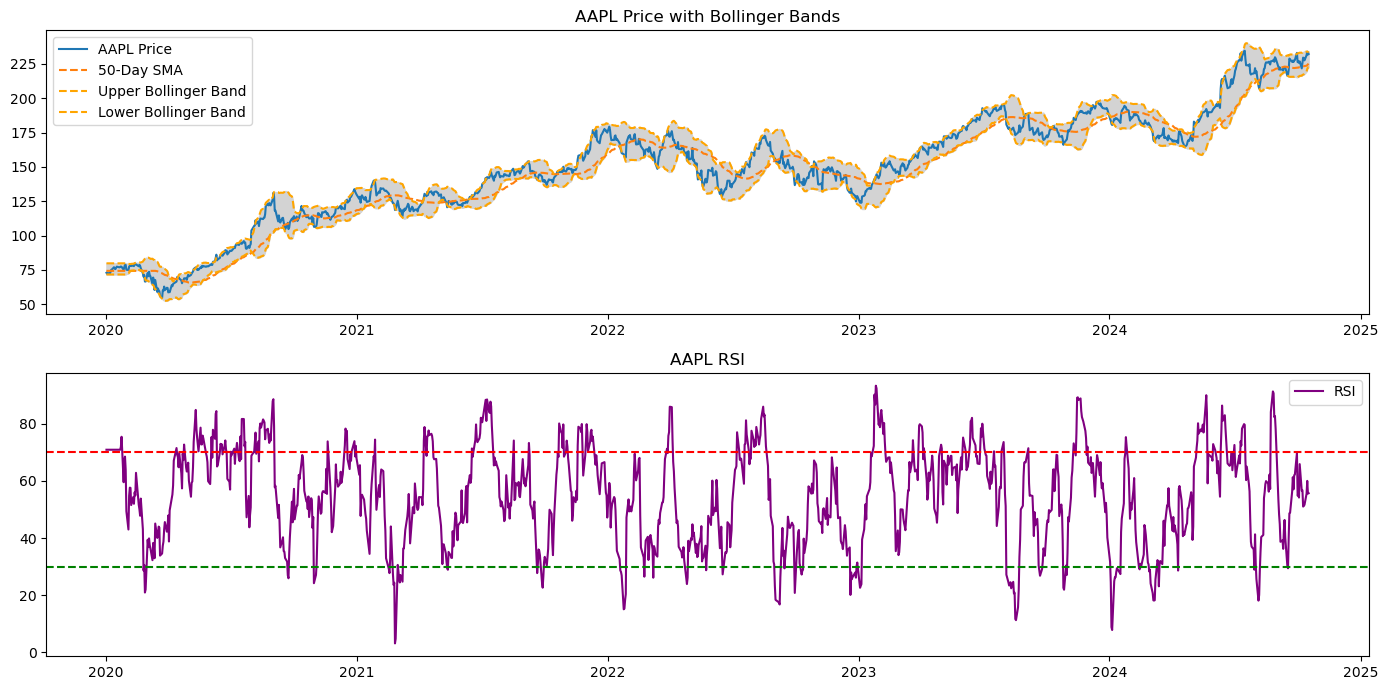

In [33]:
# Plot RSI and Bollinger Bands for a sample stock (e.g., AAPL)
ticker_sample = 'AAPL'
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(data[ticker_sample], label=f'{ticker_sample} Price')
plt.plot(sma_50[ticker_sample], label='50-Day SMA', linestyle='--')
plt.plot(upper_band[ticker_sample], label='Upper Bollinger Band', linestyle='--', color='orange')
plt.plot(lower_band[ticker_sample], label='Lower Bollinger Band', linestyle='--', color='orange')
plt.fill_between(data.index, lower_band[ticker_sample], upper_band[ticker_sample], color='lightgray')
plt.legend()
plt.title(f'{ticker_sample} Price with Bollinger Bands')
plt.subplot(2, 1, 2)
plt.plot(rsi[ticker_sample], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.legend()
plt.title(f'{ticker_sample} RSI')
plt.tight_layout()
plt.show()

In [35]:
# Prepare data for plotting
ticker_sample = 'AAPL'
data_sample = data[[ticker_sample]].copy()
data_sample['SMA_50'] = sma_50[ticker_sample]
data_sample['SMA_100'] = sma_100[ticker_sample]
data_sample['SMA_200'] = sma_200[ticker_sample]
data_sample['RSI'] = rsi[ticker_sample]
data_sample['Support'] = support[ticker_sample]
data_sample['Resistance'] = resistance[ticker_sample]

# Plot
price_plot = data_sample.hvplot.line(y=[ticker_sample, 'SMA_50', 'SMA_100', 'SMA_200'], title=f'{ticker_sample} Price with Bollinger Bands, SMA, and Resistance Levels', ylabel='Price')
support_resistance_plot = data_sample.hvplot.line(y=['Support', 'Resistance'], line_dash='dashed', color=['green', 'red'])
rsi_plot = data_sample.hvplot.line(y='RSI', title=f'{ticker_sample} RSI', ylabel='RSI').opts(yformatter='%.0f') * hv.HLine(70).opts(color='red', line_dash='dashed') * hv.HLine(30).opts(color='green', line_dash='dashed')

(price_plot * support_resistance_plot + rsi_plot).cols(1)


:Layout
   .Overlay.I  :Overlay
      .NdOverlay.I  :NdOverlay   [Ticker]
         :Curve   [Date]   (value)
      .NdOverlay.II :NdOverlay   [Ticker]
         :Curve   [Date]   (value)
   .Overlay.II :Overlay
      .Curve.I  :Curve   [Date]   (RSI)
      .HLine.I  :HLine   [x,y]
      .HLine.II :HLine   [x,y]